
# Wavelet-Based sEMG Denoising - Implementation & Testing

# Section 1: Setup and Imports

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy import signal as sp_signal
from scipy.signal import find_peaks
import warnings
warnings.filterwarnings('ignore')

# Set plotting style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

print("All imports successful")
print(f"PyWavelets version: {pywt.__version__}")

All imports successful
PyWavelets version: 1.8.0


# Section 2: Dummy sEMG Signal Generation


GENERATING SYNTHETIC sEMG SIGNAL
Generated 4000 samples at 2000 Hz
Duration: 2.00 seconds
Signal range: [-190.36, 195.79] mV


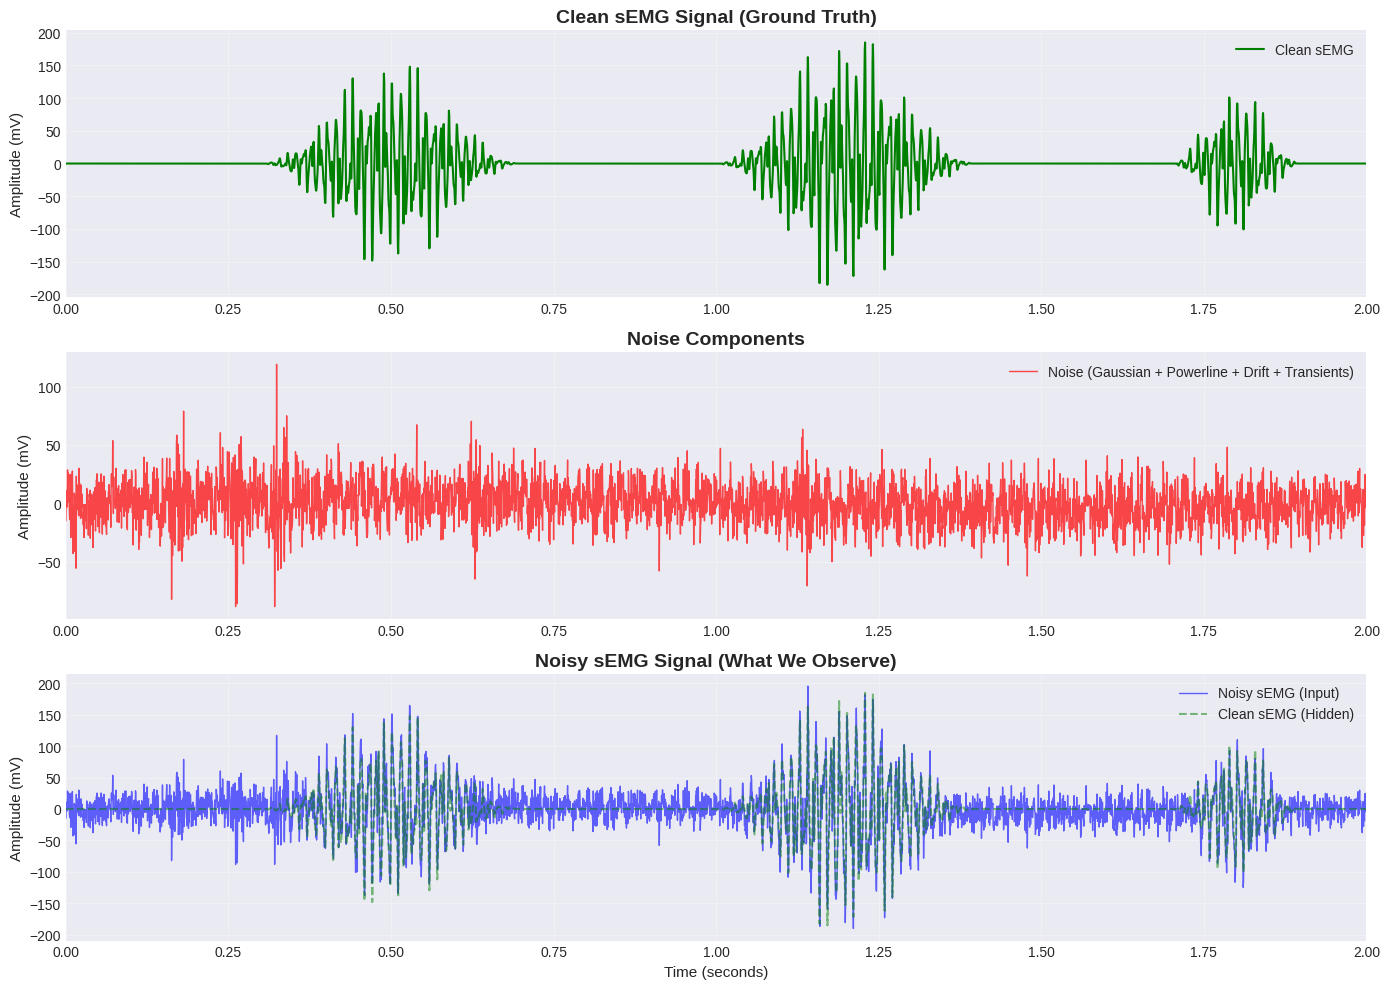


Visualization saved as '01_synthetic_semg_generation.png'


In [7]:
def generate_synthetic_semg(duration=2.0, fs=2000, activation_periods=None,
                           noise_level=15, powerline_freq=60):
    """
    Generated a realistic synthetic sEMG signal for testing. Added noise to a clean signal.

    This simulates real sEMG characteristics:
    - Multiple frequency components (20-400 Hz)
    - Activation bursts (motor unit firing)
    - Gaussian noise
    - Powerline interference (60 Hz)
    - Baseline drift

    Parameters
    ----------
    duration : float
        Signal duration in seconds
    fs : int
        Sampling frequency (Hz)
    activation_periods : list of tuples
        [(start_time, end_time, amplitude), ...] for activation bursts
    noise_level : float
        Standard deviation of Gaussian noise
    powerline_freq : float
        Powerline interference frequency (Hz)

    Returns
    -------
    t : np.ndarray
        Time vector
    clean_signal : np.ndarray
        Clean sEMG without noise
    noisy_signal : np.ndarray
        Realistic noisy sEMG signal
    """

    # Time vector
    t = np.arange(0, duration, 1/fs)
    n_samples = len(t)

    # Initialize clean signal
    clean_signal = np.zeros(n_samples)

    # Default activation periods if none provided
    if activation_periods is None:
        activation_periods = [
            (0.3, 0.7, 80),   # First burst
            (1.0, 1.4, 100),  # Second burst (stronger)
            (1.7, 1.9, 60)    # Third burst (weaker)
        ]

    # Generate activation bursts
    for start_t, end_t, amplitude in activation_periods:
        start_idx = int(start_t * fs)
        end_idx = int(end_t * fs)

        # Multi-frequency sEMG content (realistic motor unit firing)
        # sEMG typically has frequency content between 20-400 Hz
        t_burst = t[start_idx:end_idx]

        # Combine multiple frequency components
        burst = (
            amplitude * np.sin(2 * np.pi * 80 * t_burst) +      # 80 Hz
            0.6 * amplitude * np.sin(2 * np.pi * 150 * t_burst) +  # 150 Hz
            0.4 * amplitude * np.sin(2 * np.pi * 250 * t_burst) +  # 250 Hz
            0.2 * amplitude * np.sin(2 * np.pi * 350 * t_burst)    # 350 Hz
        )

        # Add envelope (gradual onset and offset)
        envelope = np.hanning(len(t_burst))
        clean_signal[start_idx:end_idx] = burst * envelope

    # Add noise components
    # 1. Gaussian white noise (electrode noise, ambient EMG)
    gaussian_noise = noise_level * np.random.randn(n_samples)

    # 2. Powerline interference (60 Hz in North America)
    powerline_noise = 8 * np.sin(2 * np.pi * powerline_freq * t)

    # 3. Low-frequency baseline drift (motion artifacts)
    baseline_drift = 5 * np.sin(2 * np.pi * 0.5 * t)

    # 4. High-frequency transient noise (spikes)
    transient_noise = np.zeros(n_samples)
    n_transients = 5
    for _ in range(n_transients):
        spike_idx = np.random.randint(0, n_samples - 50)
        transient_noise[spike_idx:spike_idx+50] = 30 * np.random.randn(50)

    # Combine all noise sources
    noisy_signal = (clean_signal + gaussian_noise + powerline_noise +
                   baseline_drift + transient_noise)

    return t, clean_signal, noisy_signal


# Generate test signal
print("\n" + "="*70)
print("GENERATING SYNTHETIC sEMG SIGNAL")
print("="*70)

t, clean_semg, noisy_semg = generate_synthetic_semg(
    duration=2.0,
    fs=2000,
    noise_level=15
)

print(f"Generated {len(t)} samples at {2000} Hz")
print(f"Duration: {t[-1]:.2f} seconds")
print(f"Signal range: [{noisy_semg.min():.2f}, {noisy_semg.max():.2f}] mV")

# Visualize the synthetic signal
fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Clean signal
axes[0].plot(t, clean_semg, 'g-', linewidth=1.5, label='Clean sEMG')
axes[0].set_title('Clean sEMG Signal (Ground Truth)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Amplitude (mV)', fontsize=11)
axes[0].legend(loc='upper right', fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim([0, 2])

# Noise only
noise = noisy_semg - clean_semg
axes[1].plot(t, noise, 'r-', alpha=0.7, linewidth=1, label='Noise (Gaussian + Powerline + Drift + Transients)')
axes[1].set_title('Noise Components', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Amplitude (mV)', fontsize=11)
axes[1].legend(loc='upper right', fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim([0, 2])

# Noisy signal
axes[2].plot(t, noisy_semg, 'b-', alpha=0.6, linewidth=1, label='Noisy sEMG (Input)')
axes[2].plot(t, clean_semg, 'g--', alpha=0.5, linewidth=1.5, label='Clean sEMG (Hidden)')
axes[2].set_title('Noisy sEMG Signal (What We Observe)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Time (seconds)', fontsize=11)
axes[2].set_ylabel('Amplitude (mV)', fontsize=11)
axes[2].legend(loc='upper right', fontsize=10)
axes[2].grid(True, alpha=0.3)
axes[2].set_xlim([0, 2])

plt.tight_layout()
plt.savefig('01_synthetic_semg_generation.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nVisualization saved as '01_synthetic_semg_generation.png'")

# Section 3: Wavelet Decomp


SECTION 3: WAVELET DECOMPOSITION VISUALIZATION


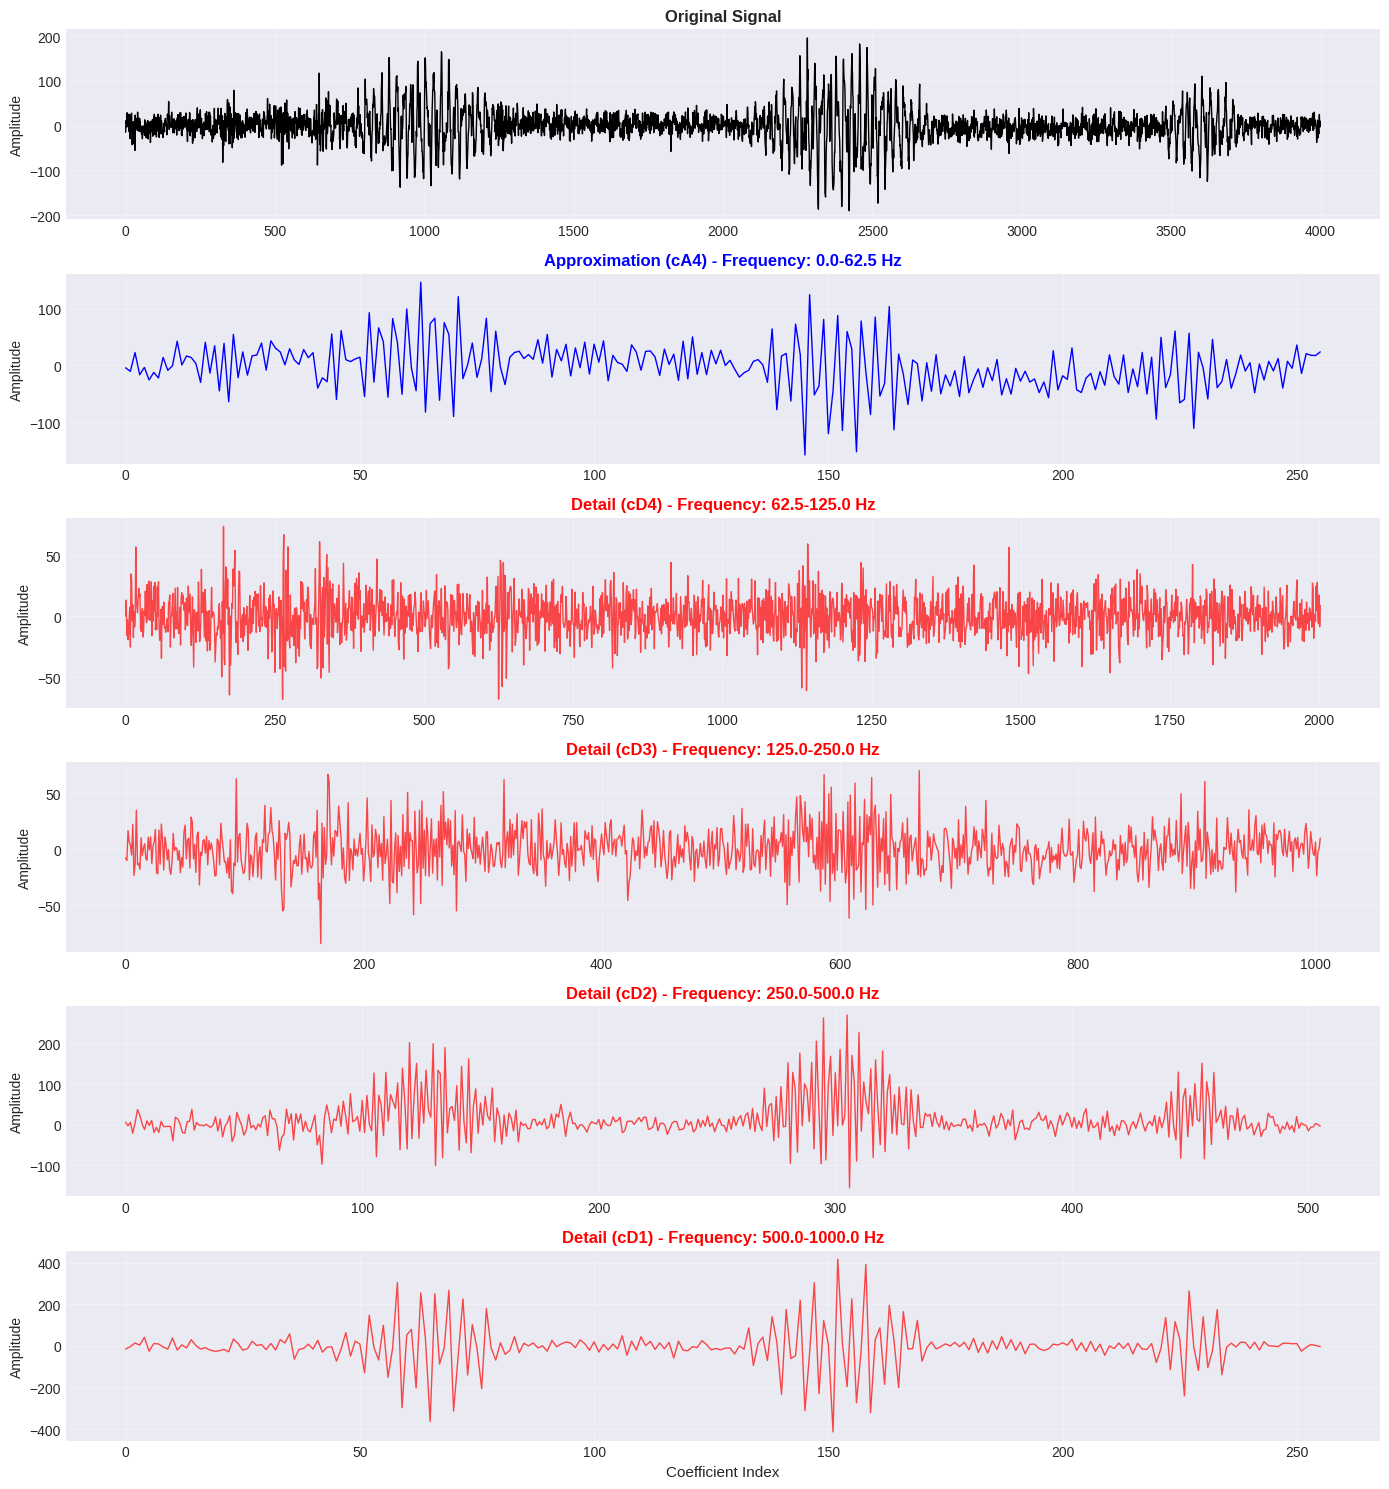


Decomposition Summary (sym4, Level 4):
------------------------------------------------------------
Component       Length     Frequency Band       Energy %  
------------------------------------------------------------
cA4             256        0.0-62.5 Hz         9.33%
cD4             2003       62.5-125.0 Hz         9.81%
cD3             1005       125.0-250.0 Hz         6.67%
cD2             506        250.0-500.0 Hz         26.40%
cD1             256        500.0-1000.0 Hz         47.79%
------------------------------------------------------------

 Visualization saved as '02_wavelet_decomposition.png'


In [8]:
print("\n" + "="*70)
print("SECTION 3: WAVELET DECOMPOSITION VISUALIZATION")
print("="*70)

def visualize_wavelet_decomposition(signal, wavelet='sym4', level=4):
    """
    This to visualize the wavelet decomposition process step-by-step.
      Took original signal and decomposed it into layers
      Muscle activations happen at 50-300hz (mid freq)
      Noise happens at 500+hz (high freq) or very low freq
      By seperating frequencies, we can target and remove noise

    This shows:
    - Original signal
    - All approximation and detail coefficients at each level
    - Frequency bands captured by each level
    """

    # Perform decomposition
    coeffs = pywt.wavedec(signal, wavelet, level=level)

    # Calculate frequency bands (assuming 2000 Hz sampling)
    fs = 2000
    freq_bands = []
    for i in range(level + 1):
        if i == 0:
            # Approximation coefficient
            freq_high = fs / (2 ** (level + 1))
            freq_bands.append((0, freq_high))
        else:
            # Detail coefficients
            freq_low = fs / (2 ** (level - i + 2))
            freq_high = fs / (2 ** (level - i + 1))
            freq_bands.append((freq_low, freq_high))

    # Create visualization
    fig, axes = plt.subplots(level + 2, 1, figsize=(14, 2.5 * (level + 2)))

    # Original signal
    axes[0].plot(signal, 'k-', linewidth=1)
    axes[0].set_title('Original Signal', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Amplitude', fontsize=10)
    axes[0].grid(True, alpha=0.3)

    # Approximation coefficients (cA)
    axes[1].plot(coeffs[0], 'b-', linewidth=1)
    axes[1].set_title(f'Approximation (cA{level}) - Frequency: {freq_bands[0][0]:.1f}-{freq_bands[0][1]:.1f} Hz',
                     fontsize=12, fontweight='bold', color='blue')
    axes[1].set_ylabel('Amplitude', fontsize=10)
    axes[1].grid(True, alpha=0.3)

    # Detail coefficients (cD)
    for i in range(1, level + 1):
        detail_idx = level - i + 1
        axes[i + 1].plot(coeffs[detail_idx], 'r-', linewidth=1, alpha=0.7)
        axes[i + 1].set_title(
            f'Detail (cD{detail_idx}) - Frequency: {freq_bands[i][0]:.1f}-{freq_bands[i][1]:.1f} Hz',
            fontsize=12, fontweight='bold', color='red'
        )
        axes[i + 1].set_ylabel('Amplitude', fontsize=10)
        axes[i + 1].grid(True, alpha=0.3)

    axes[-1].set_xlabel('Coefficient Index', fontsize=11)

    plt.tight_layout()
    plt.savefig('02_wavelet_decomposition.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Print summary
    print(f"\nDecomposition Summary ({wavelet}, Level {level}):")
    print("-" * 60)
    print(f"{'Component':<15} {'Length':<10} {'Frequency Band':<20} {'Energy %':<10}")
    print("-" * 60)

    total_energy = sum(np.sum(c**2) for c in coeffs)

    print(f"cA{level:<13} {len(coeffs[0]):<10} "
          f"{freq_bands[0][0]:.1f}-{freq_bands[0][1]:.1f} Hz{'':<8} "
          f"{100 * np.sum(coeffs[0]**2) / total_energy:.2f}%")

    for i in range(1, level + 1):
        detail_idx = level - i + 1
        print(f"cD{detail_idx:<13} {len(coeffs[detail_idx]):<10} "
              f"{freq_bands[i][0]:.1f}-{freq_bands[i][1]:.1f} Hz{'':<8} "
              f"{100 * np.sum(coeffs[detail_idx]**2) / total_energy:.2f}%")

    print("-" * 60)

    return coeffs, freq_bands


# Visualize decomposition
coeffs, freq_bands = visualize_wavelet_decomposition(noisy_semg, wavelet='sym4', level=4)

print("\n Visualization saved as '02_wavelet_decomposition.png'")


# Section 4: Understanding Diff Mother Wavelets


SECTION 4: COMPARING DIFFERENT MOTHER WAVELETS


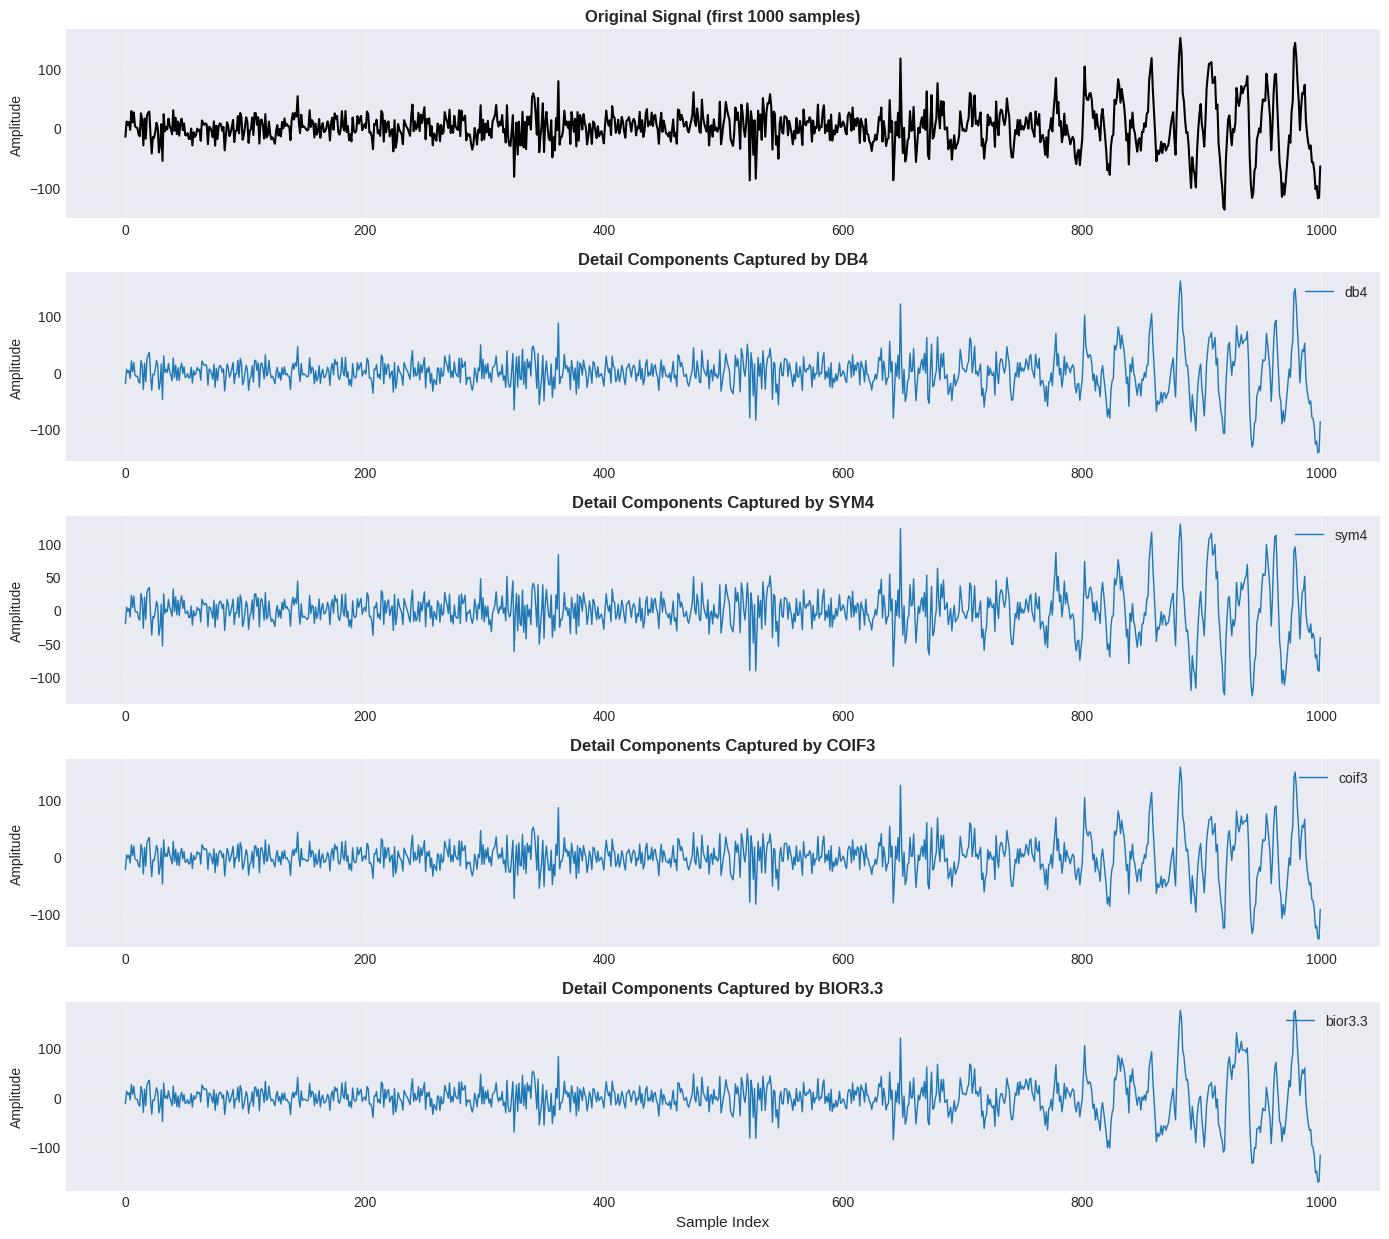

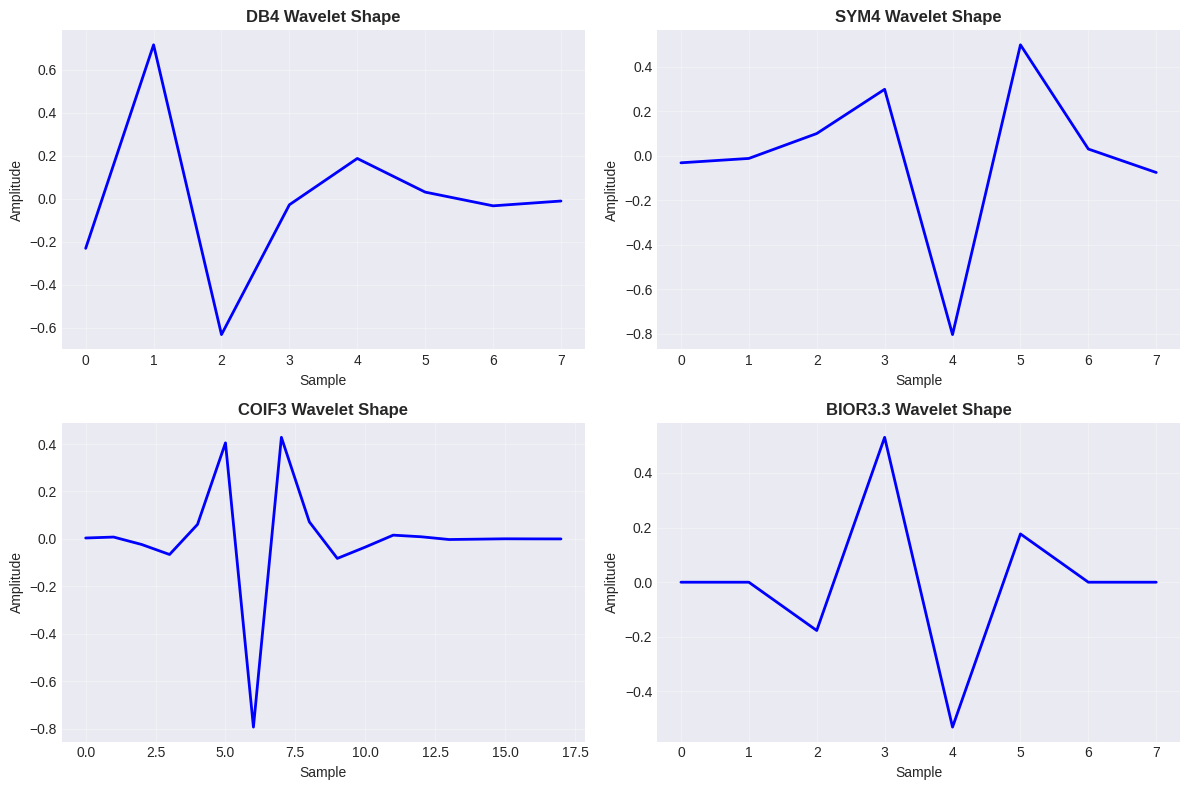


Wavelet comparison saved

Wavelet Characteristics:
------------------------------------------------------------
Wavelet      Family          Symmetry        Best For
------------------------------------------------------------
db4          Daubechies      Asymmetric      Sharp transients, good for capturing sudden changes
sym4         Symlets         Near-symmetric  balanced, recommended for sEMG
coif3        Coiflets        Symmetric       Smooth signals
bior3.3      Biorthogonal    Symmetric       Image/signals
------------------------------------------------------------


In [9]:
print("\n" + "="*70)
print("SECTION 4: COMPARING DIFFERENT MOTHER WAVELETS")
print("="*70)

def compare_mother_wavelets(signal, wavelets=None):
    """

    Why do we have diff wavelets (db4, sym4. coif3)?
    Because they're like diff types of filters

    This function compares different mother wavelets visually
    and shows how different wavelets decompose the same signal.

    Out of the 3, sym4 should be used for sEMG because:
      - doesnt shift the timing of muscle activations
       (which is critical because we need to know WHEN the finger moved)
    """

    if wavelets is None:
        wavelets = ['db4', 'sym4', 'coif3', 'bior3.3']

    fig, axes = plt.subplots(len(wavelets) + 1, 1, figsize=(14, 2.5 * (len(wavelets) + 1)))

    # Original signal
    axes[0].plot(signal[:1000], 'k-', linewidth=1.5)
    axes[0].set_title('Original Signal (first 1000 samples)',
                     fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Amplitude', fontsize=10)
    axes[0].grid(True, alpha=0.3)

    # Compare wavelets
    for idx, wavelet in enumerate(wavelets, 1):
        coeffs = pywt.wavedec(signal, wavelet, level=4)

        # Reconstruct from level 4 detail only (shows what wavelet captures)
        coeffs_detail_only = [np.zeros_like(coeffs[0])] + [coeffs[i] for i in range(1, len(coeffs))]
        detail_signal = pywt.waverec(coeffs_detail_only, wavelet)

        # Handle length mismatch
        if len(detail_signal) > len(signal):
            detail_signal = detail_signal[:len(signal)]

        axes[idx].plot(detail_signal[:1000], linewidth=1, label=f'{wavelet}')
        axes[idx].set_title(f'Detail Components Captured by {wavelet.upper()}',
                          fontsize=12, fontweight='bold')
        axes[idx].set_ylabel('Amplitude', fontsize=10)
        axes[idx].legend(loc='upper right')
        axes[idx].grid(True, alpha=0.3)

    axes[-1].set_xlabel('Sample Index', fontsize=11)

    plt.tight_layout()
    plt.savefig('03_mother_wavelet_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Show wavelet shapes - FIXED VERSION
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.ravel()

    for idx, wavelet in enumerate(wavelets):
        try:
            # Try the new method name first (PyWavelets >= 1.0)
            wav = pywt.Wavelet(wavelet)
            if hasattr(wav, 'wavefun'):
                # New versions use wavefun
                psi, x = wav.wavefun(level=8)
            else:
                # Older versions might use other methods
                # Generate approximation manually
                [psi, x], [phi, x2] = pywt.ContinuousWavelet(wavelet).wavefun(level=8)
        except:
            # Fallback: use discrete wavelet filters
            try:
                wav = pywt.Wavelet(wavelet)
                # Get filter coefficients
                dec_lo, dec_hi, rec_lo, rec_hi = wav.filter_bank
                psi = np.array(dec_hi)
                x = np.arange(len(psi))
            except:
                # Ultimate fallback: skip this wavelet
                axes[idx].text(0.5, 0.5, f'Could not generate\n{wavelet} shape',
                             ha='center', va='center', fontsize=12)
                axes[idx].set_title(f'{wavelet.upper()} Wavelet',
                                  fontsize=12, fontweight='bold')
                continue

        axes[idx].plot(x, psi, 'b-', linewidth=2)
        axes[idx].set_title(f'{wavelet.upper()} Wavelet Shape',
                          fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Sample', fontsize=10)
        axes[idx].set_ylabel('Amplitude', fontsize=10)
        axes[idx].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('04_wavelet_shapes.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("\nWavelet comparison saved")
    print("\nWavelet Characteristics:")
    print("-" * 60)
    print(f"{'Wavelet':<12} {'Family':<15} {'Symmetry':<15} {'Best For'}")
    print("-" * 60)
    print(f"{'db4':<12} {'Daubechies':<15} {'Asymmetric':<15} {'Sharp transients, good for capturing sudden changes'}")
    print(f"{'sym4':<12} {'Symlets':<15} {'Near-symmetric':<15} {'balanced, recommended for sEMG'}")
    print(f"{'coif3':<12} {'Coiflets':<15} {'Symmetric':<15} {'Smooth signals'}")
    print(f"{'bior3.3':<12} {'Biorthogonal':<15} {'Symmetric':<15} {'Image/signals'}")
    print("-" * 60)


compare_mother_wavelets(noisy_semg)

# Section 5: Thresholding Methods


SECTION 5: UNDERSTANDING THRESHOLDING

Noise Estimation:
  Estimated σ (MAD): 15.38
  Universal threshold: 62.65


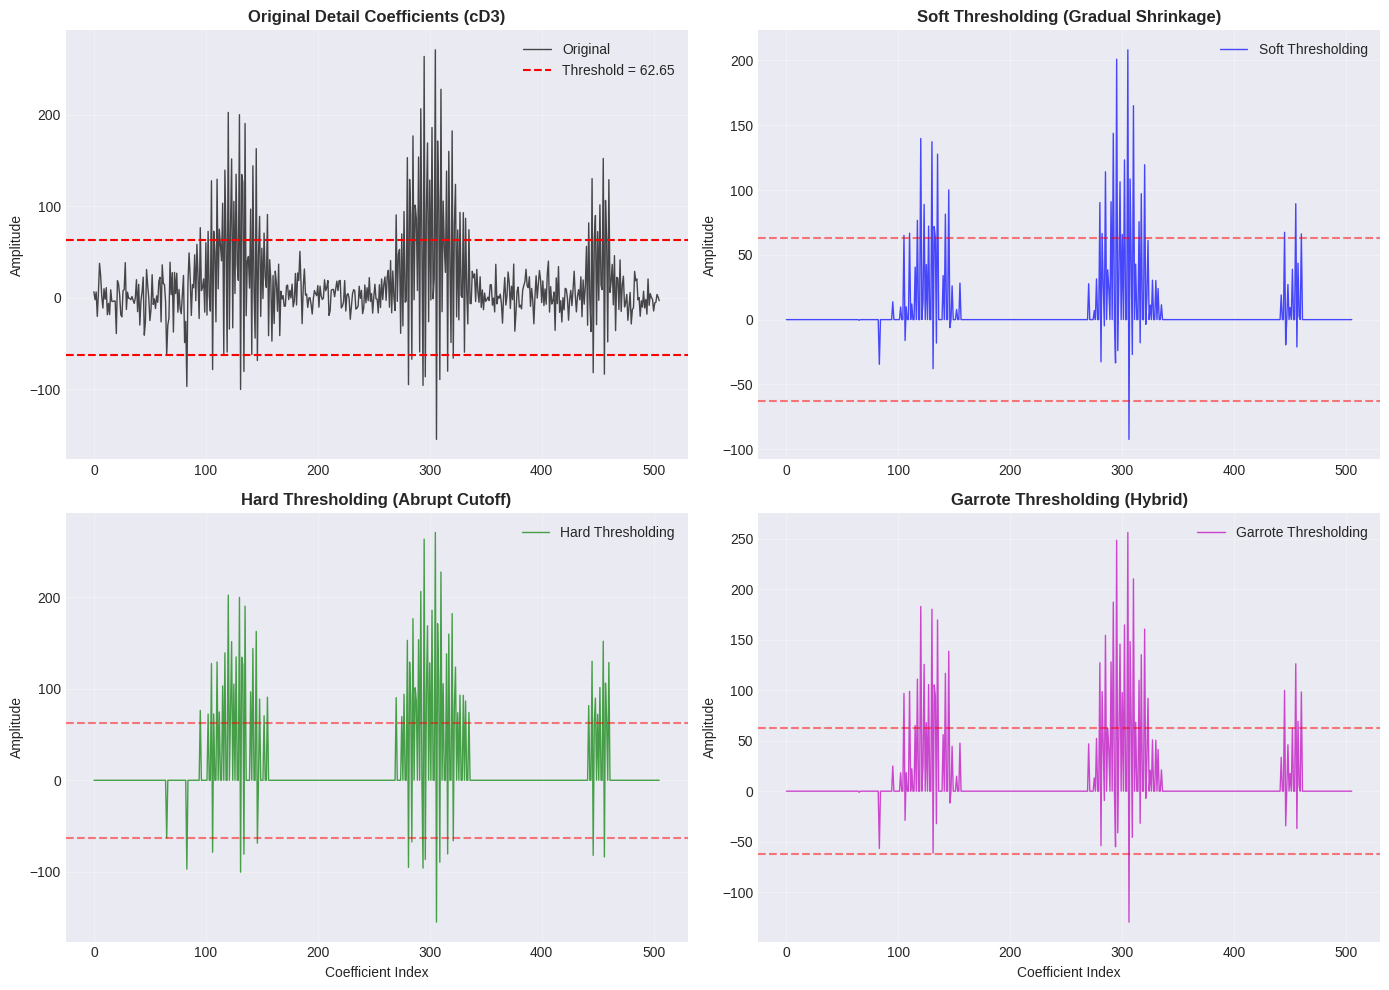

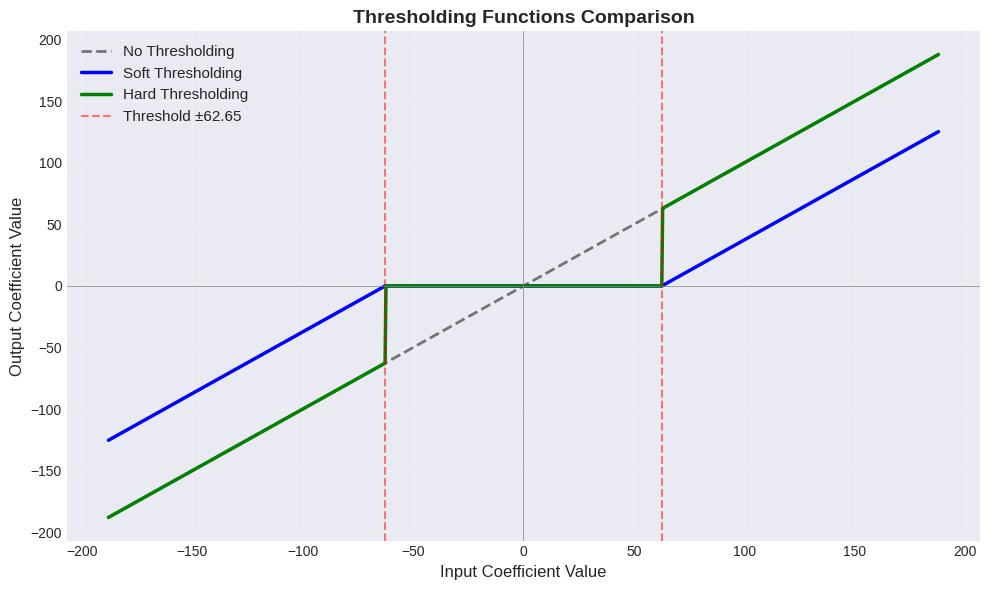


Thresholding visualizations saved

Thresholding Method Characteristics:
----------------------------------------------------------------------
Soft Thresholding:
  • Shrinks all coefficients by threshold amount
  • Formula: sign(x) * max(|x| - λ, 0)
  • Pro: Smooth, reduces artifacts
  • Con: Can over-smooth sharp features
  • USE FOR: sEMG signals

Hard Thresholding:
  • Keeps coefficient unchanged or sets to zero
  • Formula: x if |x| > λ, else 0
  • Pro: Preserves large features exactly
  • Con: Can create discontinuities
  • USE FOR: Signals with sparse spikes

Garrote Thresholding:
  • Compromise between soft and hard
  • Formula: x - λ²/x if |x| > λ, else 0
  • Pro: Adaptive shrinkage
  • Con: More complex, less intuitive
  • USE FOR: Experimental comparison
----------------------------------------------------------------------


In [10]:
print("\n" + "="*70)
print("SECTION 5: UNDERSTANDING THRESHOLDING")
print("="*70)

def demonstrate_thresholding(signal, wavelet='sym4', level=4):
    """
    This function visually demonstrates different thresholding methods.

    After breaking signal into freq bands, we need to decide which parts
    are noise and should be removed.

    Threshold Rule:
        - coeff > threshould -> keep it, its a signal
        - coeff < threshold -> remove it, its a noise

    There are 3 types of thresholding:
      1. Soft (what we'll use)
          - gradual remove
          - smooth results
          - Best for sEMG because muscle activations need smooth transitions

      2. Hard
          - abrupt cutoff (keep or kill)
          - keeps big signals exactly as they are
          - can create sudden jumps (artifacts)

      3. Garrote
          - middle ground bw soft and hard
          - but less commonly used

    """

    # Decompose
    coeffs = pywt.wavedec(signal, wavelet, level=level)

    # Estimate noise
    sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    N = len(signal)
    threshold = sigma * np.sqrt(2 * np.log(N))

    print(f"\nNoise Estimation:")
    print(f"  Estimated σ (MAD): {sigma:.2f}")
    print(f"  Universal threshold: {threshold:.2f}")

    # Get detail coefficients at level 3 for visualization
    detail_coeffs = coeffs[2]  # cD3

    # Apply different thresholding
    soft_thresh = pywt.threshold(detail_coeffs, threshold, mode='soft')
    hard_thresh = pywt.threshold(detail_coeffs, threshold, mode='hard')
    garrote_thresh = pywt.threshold(detail_coeffs, threshold, mode='garotte')

    # Visualize
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Original coefficients
    axes[0, 0].plot(detail_coeffs, 'k-', linewidth=1, alpha=0.7, label='Original')
    axes[0, 0].axhline(y=threshold, color='r', linestyle='--', label=f'Threshold = {threshold:.2f}')
    axes[0, 0].axhline(y=-threshold, color='r', linestyle='--')
    axes[0, 0].set_title('Original Detail Coefficients (cD3)', fontsize=12, fontweight='bold')
    axes[0, 0].set_ylabel('Amplitude', fontsize=10)
    axes[0, 0].legend(fontsize=10)
    axes[0, 0].grid(True, alpha=0.3)

    # Soft thresholding
    axes[0, 1].plot(soft_thresh, 'b-', linewidth=1, alpha=0.7, label='Soft Thresholding')
    axes[0, 1].axhline(y=threshold, color='r', linestyle='--', alpha=0.5)
    axes[0, 1].axhline(y=-threshold, color='r', linestyle='--', alpha=0.5)
    axes[0, 1].set_title('Soft Thresholding (Gradual Shrinkage)', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('Amplitude', fontsize=10)
    axes[0, 1].legend(fontsize=10)
    axes[0, 1].grid(True, alpha=0.3)

    # Hard thresholding
    axes[1, 0].plot(hard_thresh, 'g-', linewidth=1, alpha=0.7, label='Hard Thresholding')
    axes[1, 0].axhline(y=threshold, color='r', linestyle='--', alpha=0.5)
    axes[1, 0].axhline(y=-threshold, color='r', linestyle='--', alpha=0.5)
    axes[1, 0].set_title('Hard Thresholding (Abrupt Cutoff)', fontsize=12, fontweight='bold')
    axes[1, 0].set_xlabel('Coefficient Index', fontsize=10)
    axes[1, 0].set_ylabel('Amplitude', fontsize=10)
    axes[1, 0].legend(fontsize=10)
    axes[1, 0].grid(True, alpha=0.3)

    # Garrote thresholding
    axes[1, 1].plot(garrote_thresh, 'm-', linewidth=1, alpha=0.7, label='Garrote Thresholding')
    axes[1, 1].axhline(y=threshold, color='r', linestyle='--', alpha=0.5)
    axes[1, 1].axhline(y=-threshold, color='r', linestyle='--', alpha=0.5)
    axes[1, 1].set_title('Garrote Thresholding (Hybrid)', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Coefficient Index', fontsize=10)
    axes[1, 1].set_ylabel('Amplitude', fontsize=10)
    axes[1, 1].legend(fontsize=10)
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('05_thresholding_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

    # Show thresholding function mathematically
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))

    x = np.linspace(-3*threshold, 3*threshold, 1000)

    # Soft thresholding function
    y_soft = np.sign(x) * np.maximum(np.abs(x) - threshold, 0)

    # Hard thresholding function
    y_hard = x * (np.abs(x) > threshold)

    # Identity (no thresholding)
    y_identity = x

    ax.plot(x, y_identity, 'k--', linewidth=2, label='No Thresholding', alpha=0.5)
    ax.plot(x, y_soft, 'b-', linewidth=2.5, label='Soft Thresholding')
    ax.plot(x, y_hard, 'g-', linewidth=2.5, label='Hard Thresholding')
    ax.axvline(x=threshold, color='r', linestyle='--', alpha=0.5, label=f'Threshold ±{threshold:.2f}')
    ax.axvline(x=-threshold, color='r', linestyle='--', alpha=0.5)
    ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
    ax.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)

    ax.set_xlabel('Input Coefficient Value', fontsize=12)
    ax.set_ylabel('Output Coefficient Value', fontsize=12)
    ax.set_title('Thresholding Functions Comparison', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('06_thresholding_functions.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("\nThresholding visualizations saved")

    print("\nThresholding Method Characteristics:")
    print("-" * 70)
    print("Soft Thresholding:")
    print("  • Shrinks all coefficients by threshold amount")
    print("  • Formula: sign(x) * max(|x| - λ, 0)")
    print("  • Pro: Smooth, reduces artifacts")
    print("  • Con: Can over-smooth sharp features")
    print("  • USE FOR: sEMG signals")
    print()
    print("Hard Thresholding:")
    print("  • Keeps coefficient unchanged or sets to zero")
    print("  • Formula: x if |x| > λ, else 0")
    print("  • Pro: Preserves large features exactly")
    print("  • Con: Can create discontinuities")
    print("  • USE FOR: Signals with sparse spikes")
    print()
    print("Garrote Thresholding:")
    print("  • Compromise between soft and hard")
    print("  • Formula: x - λ²/x if |x| > λ, else 0")
    print("  • Pro: Adaptive shrinkage")
    print("  • Con: More complex, less intuitive")
    print("  • USE FOR: Experimental comparison")
    print("-" * 70)


demonstrate_thresholding(noisy_semg)

# Section 6: Wavelet Denoising - MAIN FUNCTION


SECTION 6: COMPLETE WAVELET DENOISING FUNCTION

Applying wavelet denoising

Denoising complete!
  SNR Before: 5.24 dB
  SNR After:  6.10 dB
  SNR Improvement: 0.86 dB
  Correlation with clean signal: 0.8801


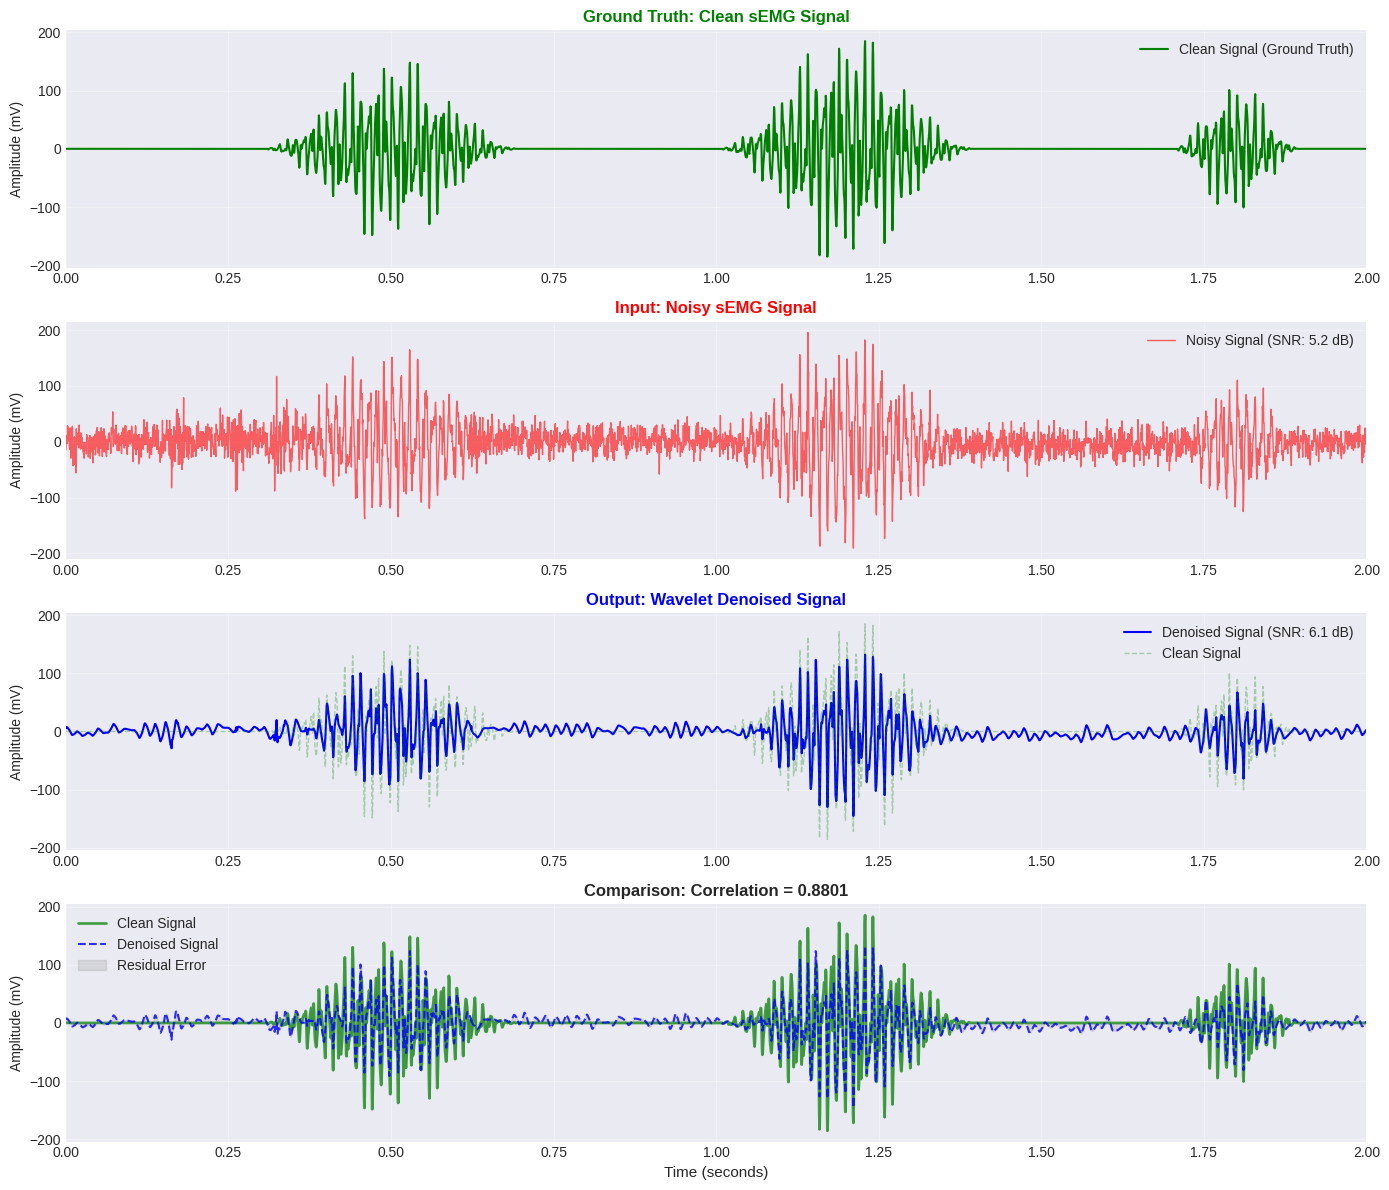


Results visualization saved as '07_denoising_results.png'


In [11]:
print("\n" + "="*70)
print("SECTION 6: COMPLETE WAVELET DENOISING FUNCTION")
print("="*70)

def wavelet_denoise(signal, wavelet='sym4', level=4, threshold_mode='soft',
                   threshold_method='universal', noise_est='median'):
    """
    This is the actual wavelet denoising implementation.

    1. Breaks signal into freq bands
    2. Estimates how much noise is in the signal
    3. Calculates threshold (how aggressive it needs to be)
    4. Applies threshold to each freq band
    5. Reconstructs the signal from cleaned coeffients
    """

    # Input validation
    if not isinstance(signal, np.ndarray):
        signal = np.array(signal)

    if signal.ndim != 1:
        raise ValueError(f"Expected 1D signal, got shape {signal.shape}")

    if len(signal) == 0:
        raise ValueError("Cannot denoise empty signal")

    # Check signal length
    min_length = 2 ** level
    if len(signal) < min_length:
        warnings.warn(f"Signal too short for level {level}, reducing to {int(np.log2(len(signal)))}")
        level = int(np.log2(len(signal)))

    # Decompose
    coeffs = pywt.wavedec(signal, wavelet, level=level)

    # Estimate noise
    if noise_est == 'median':
        sigma = np.median(np.abs(coeffs[-1])) / 0.6745
    else:
        sigma = np.std(coeffs[-1])

    # Calculate threshold
    N = len(signal)

    if threshold_method == 'universal':
        threshold = sigma * np.sqrt(2 * np.log(N))
    elif threshold_method == 'minimax':
        if N > 32:
            threshold = sigma * (0.3936 + 0.1829 * np.log2(N))
        else:
            threshold = 0
    elif threshold_method == 'sure':
        threshold = _sure_threshold(coeffs[-1], sigma)
    else:
        raise ValueError(f"Unknown threshold method: {threshold_method}")

    # Apply thresholding
    coeffs_thresh = [coeffs[0]]  # Keep approximation

    for i in range(1, len(coeffs)):
        coeffs_thresh.append(pywt.threshold(coeffs[i], threshold, mode=threshold_mode))

    # Reconstruct
    denoised = pywt.waverec(coeffs_thresh, wavelet)

    # Handle length mismatch
    if len(denoised) > len(signal):
        denoised = denoised[:len(signal)]
    elif len(denoised) < len(signal):
        denoised = np.pad(denoised, (0, len(signal) - len(denoised)), mode='edge')

    return denoised


def _sure_threshold(detail_coeffs, sigma):
    """SURE threshold calculation"""
    N = len(detail_coeffs)
    abs_coeffs = np.abs(detail_coeffs)
    abs_coeffs_sorted = np.sort(abs_coeffs)

    risks = np.zeros(N)
    for k in range(N):
        threshold = abs_coeffs_sorted[k]
        risks[k] = (N - 2 * (k + 1) +
                   np.sum(np.minimum(abs_coeffs, threshold)**2) +
                   (k + 1) * threshold**2) / N

    min_risk_idx = np.argmin(risks)
    optimal_threshold = abs_coeffs_sorted[min_risk_idx]

    return optimal_threshold * sigma


# Apply denoising
print("\nApplying wavelet denoising")
denoised_semg = wavelet_denoise(noisy_semg, wavelet='sym4', level=4,
                                 threshold_mode='soft', threshold_method='universal')

# Calculate metrics
snr_before = 10 * np.log10(np.sum(clean_semg**2) / np.sum((noisy_semg - clean_semg)**2))
snr_after = 10 * np.log10(np.sum(clean_semg**2) / np.sum((denoised_semg - clean_semg)**2))
correlation = np.corrcoef(clean_semg, denoised_semg)[0, 1]

print(f"\nDenoising complete!")
print(f"  SNR Before: {snr_before:.2f} dB")
print(f"  SNR After:  {snr_after:.2f} dB")
print(f"  SNR Improvement: {snr_after - snr_before:.2f} dB")
print(f"  Correlation with clean signal: {correlation:.4f}")

# Visualize results
fig, axes = plt.subplots(4, 1, figsize=(14, 12))

# Clean signal (ground truth)
axes[0].plot(t, clean_semg, 'g-', linewidth=1.5, label='Clean Signal (Ground Truth)')
axes[0].set_title('Ground Truth: Clean sEMG Signal', fontsize=12, fontweight='bold', color='green')
axes[0].set_ylabel('Amplitude (mV)', fontsize=10)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim([0, 2])

# Noisy signal (input)
axes[1].plot(t, noisy_semg, 'r-', alpha=0.6, linewidth=1, label=f'Noisy Signal (SNR: {snr_before:.1f} dB)')
axes[1].set_title('Input: Noisy sEMG Signal', fontsize=12, fontweight='bold', color='red')
axes[1].set_ylabel('Amplitude (mV)', fontsize=10)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim([0, 2])

# Denoised signal (output)
axes[2].plot(t, denoised_semg, 'b-', linewidth=1.5, label=f'Denoised Signal (SNR: {snr_after:.1f} dB)')
axes[2].plot(t, clean_semg, 'g--', alpha=0.3, linewidth=1, label='Clean Signal')
axes[2].set_title('Output: Wavelet Denoised Signal', fontsize=12, fontweight='bold', color='blue')
axes[2].set_ylabel('Amplitude (mV)', fontsize=10)
axes[2].legend(fontsize=10)
axes[2].grid(True, alpha=0.3)
axes[2].set_xlim([0, 2])

# Comparison overlay
axes[3].plot(t, clean_semg, 'g-', linewidth=2, alpha=0.7, label='Clean Signal')
axes[3].plot(t, denoised_semg, 'b--', linewidth=1.5, alpha=0.8, label='Denoised Signal')
axes[3].fill_between(t, clean_semg, denoised_semg, alpha=0.2, color='gray', label='Residual Error')
axes[3].set_title(f'Comparison: Correlation = {correlation:.4f}',
                 fontsize=12, fontweight='bold')
axes[3].set_xlabel('Time (seconds)', fontsize=11)
axes[3].set_ylabel('Amplitude (mV)', fontsize=10)
axes[3].legend(fontsize=10)
axes[3].grid(True, alpha=0.3)
axes[3].set_xlim([0, 2])

plt.tight_layout()
plt.savefig('07_denoising_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nResults visualization saved as '07_denoising_results.png'")

# Section 7: Exploring Diff Parameters


SECTION 7: EXPLORING DIFFERENT PARAMETERS

Testing parameter combinations.
--------------------------------------------------------------------------------
Wavelet    Level    Mode       SNR (dB)     Correlation  Score     
--------------------------------------------------------------------------------
db4        3        soft       7.27         0.9017       0.3101    
db4        3        hard       8.95         0.9387       0.3900    
db4        4        soft       6.39         0.8931       0.2444    
db4        4        hard       9.21         0.9412       0.4101    
db4        5        soft       6.33         0.9057       0.2509    
db4        5        hard       9.38         0.9427       0.4262    
sym4       3        soft       6.86         0.8913       0.2728    
sym4       3        hard       8.18         0.9262       0.3586    
sym4       4        soft       6.10         0.8801       0.2445    
sym4       4        hard       8.49         0.9304       0.3737    
sym4       5  

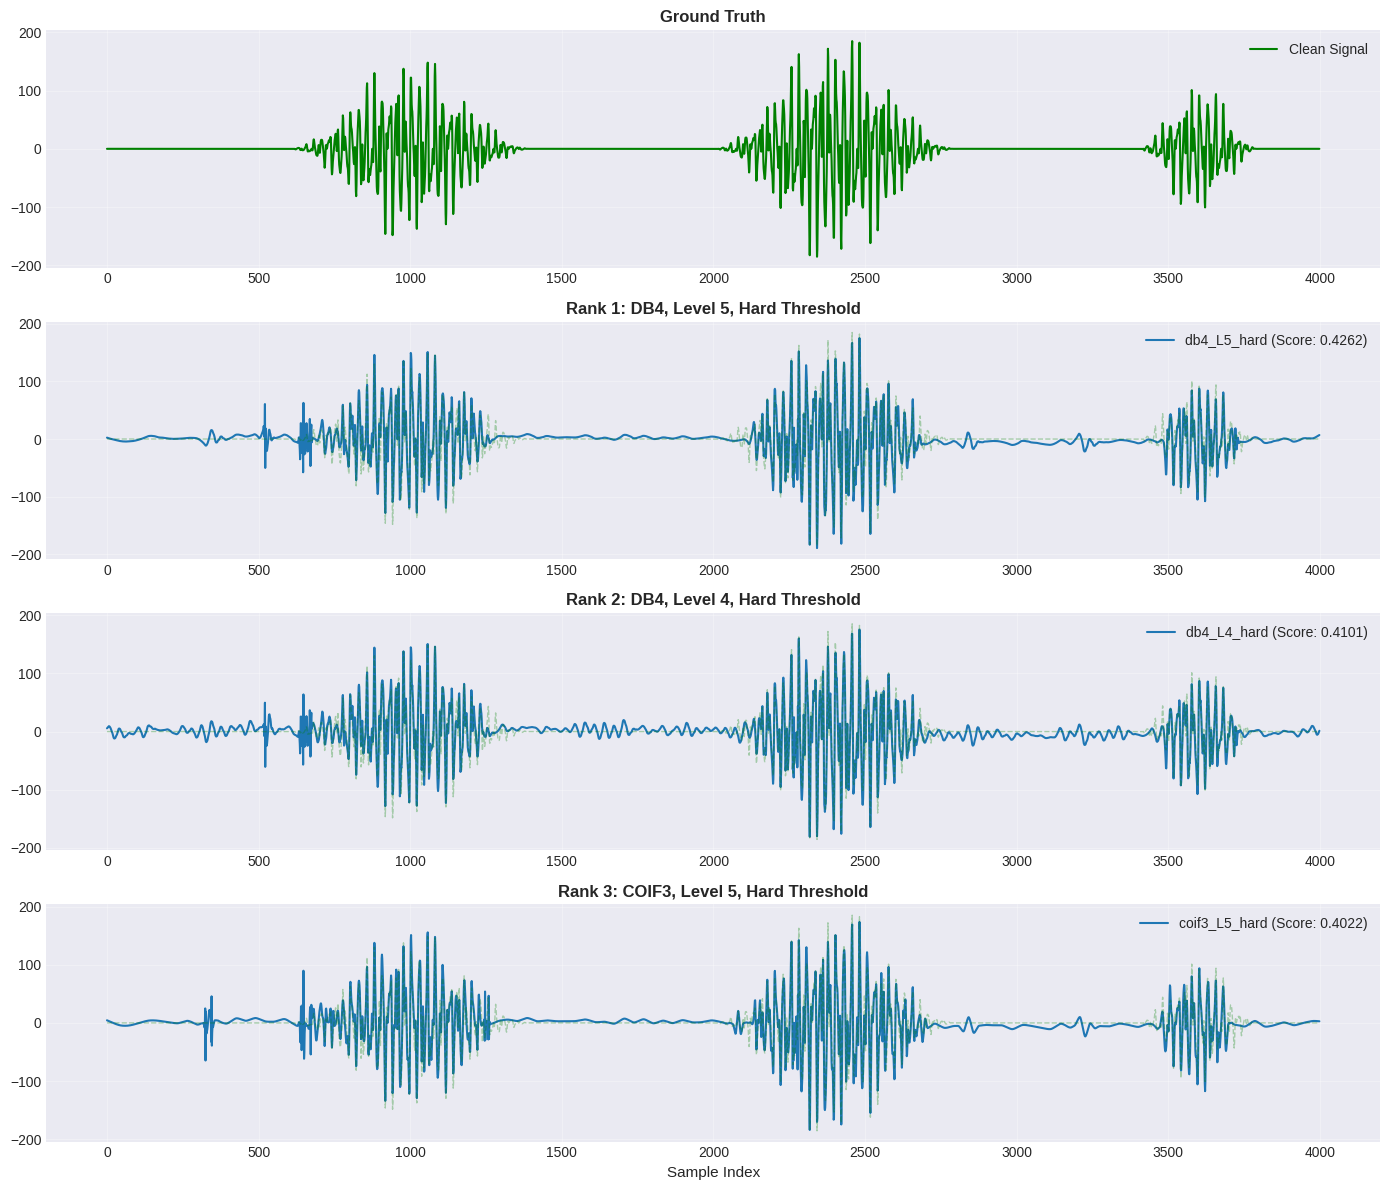


Parameter comparison saved as '08_parameter_comparison.png'


In [12]:
print("\n" + "="*70)
print("SECTION 7: EXPLORING DIFFERENT PARAMETERS")
print("="*70)

def compare_denoising_parameters(signal, clean_signal, fs=2000):
    """
    Compares different denoising parameters.

    The code tries:
      - Different wavelets (sym4, db4, coif3)
      - Different levels (3, 4, 5)
      - Different thresholding modes (soft, hard)

    And measures:
    - SNR: Signal-to-Noise Ratio (higher = better)
    - Correlation: How similar to original clean signal (closer to 1 = better)
    - Peak preservation: Are muscle activation bursts still there?

    Results show: db4 wavelet, level 5, hard threshold

    """

    wavelets = ['db4', 'sym4', 'coif3']
    levels = [3, 4, 5]
    threshold_modes = ['soft', 'hard']

    results = []

    print("\nTesting parameter combinations.")
    print("-" * 80)
    print(f"{'Wavelet':<10} {'Level':<8} {'Mode':<10} {'SNR (dB)':<12} {'Correlation':<12} {'Score':<10}")
    print("-" * 80)

    for wavelet in wavelets:
        for level in levels:
            for mode in threshold_modes:
                try:
                    # Denoise
                    denoised = wavelet_denoise(signal, wavelet=wavelet,
                                              level=level, threshold_mode=mode)

                    # Calculate metrics
                    snr = 10 * np.log10(np.sum(clean_signal**2) /
                                       np.sum((denoised - clean_signal)**2))
                    corr = np.corrcoef(clean_signal, denoised)[0, 1]

                    # Peak preservation
                    peak_pres = _calculate_peak_preservation(clean_signal, denoised)

                    # Combined score
                    score = (snr / 20) * corr * peak_pres  # Normalized

                    results.append({
                        'wavelet': wavelet,
                        'level': level,
                        'mode': mode,
                        'snr': snr,
                        'correlation': corr,
                        'peak_preservation': peak_pres,
                        'score': score,
                        'denoised': denoised
                    })

                    print(f"{wavelet:<10} {level:<8} {mode:<10} {snr:<12.2f} "
                          f"{corr:<12.4f} {score:<10.4f}")

                except Exception as e:
                    print(f"{wavelet:<10} {level:<8} {mode:<10} FAILED: {str(e)}")

    print("-" * 80)

    # Find best configuration
    best_result = max(results, key=lambda x: x['score'])

    print(f"\nBEST CONFIGURATION:")
    print(f"   Wavelet: {best_result['wavelet']}")
    print(f"   Level: {best_result['level']}")
    print(f"   Threshold Mode: {best_result['mode']}")
    print(f"   SNR: {best_result['snr']:.2f} dB")
    print(f"   Correlation: {best_result['correlation']:.4f}")
    print(f"   Peak Preservation: {best_result['peak_preservation']:.4f}")
    print(f"   Combined Score: {best_result['score']:.4f}")

    # Visualize top 3 configurations
    sorted_results = sorted(results, key=lambda x: x['score'], reverse=True)[:3]

    fig, axes = plt.subplots(4, 1, figsize=(14, 12))

    # Ground truth
    axes[0].plot(clean_signal, 'g-', linewidth=1.5, label='Clean Signal')
    axes[0].set_title('Ground Truth', fontsize=12, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Top 3 configurations
    for idx, result in enumerate(sorted_results, 1):
        axes[idx].plot(result['denoised'], linewidth=1.5,
                      label=f"{result['wavelet']}_L{result['level']}_{result['mode']} "
                            f"(Score: {result['score']:.4f})")
        axes[idx].plot(clean_signal, 'g--', alpha=0.3, linewidth=1)
        axes[idx].set_title(f"Rank {idx}: {result['wavelet'].upper()}, "
                          f"Level {result['level']}, {result['mode'].capitalize()} Threshold",
                          fontsize=12, fontweight='bold')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)

    axes[-1].set_xlabel('Sample Index', fontsize=11)

    plt.tight_layout()
    plt.savefig('08_parameter_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("\nParameter comparison saved as '08_parameter_comparison.png'")

    return results, best_result


def _calculate_peak_preservation(original, denoised, percentile=95):
    """Calculate peak preservation score"""
    threshold_orig = np.percentile(np.abs(original), percentile)
    threshold_denoised = np.percentile(np.abs(denoised), percentile)

    peaks_orig, _ = find_peaks(np.abs(original), height=threshold_orig)
    peaks_denoised, _ = find_peaks(np.abs(denoised), height=threshold_denoised)

    if len(peaks_orig) == 0 or len(peaks_denoised) == 0:
        return 0.0

    tolerance = 20
    matches = sum(1 for peak in peaks_orig
                 if np.any(np.abs(peaks_denoised - peak) <= tolerance))

    return matches / len(peaks_orig)


# Run parameter comparison
results, best_config = compare_denoising_parameters(noisy_semg, clean_semg)

# Section 8: Analysis of Activation Bursts


SECTION 8: DETAILED ACTIVATION BURST ANALYSIS


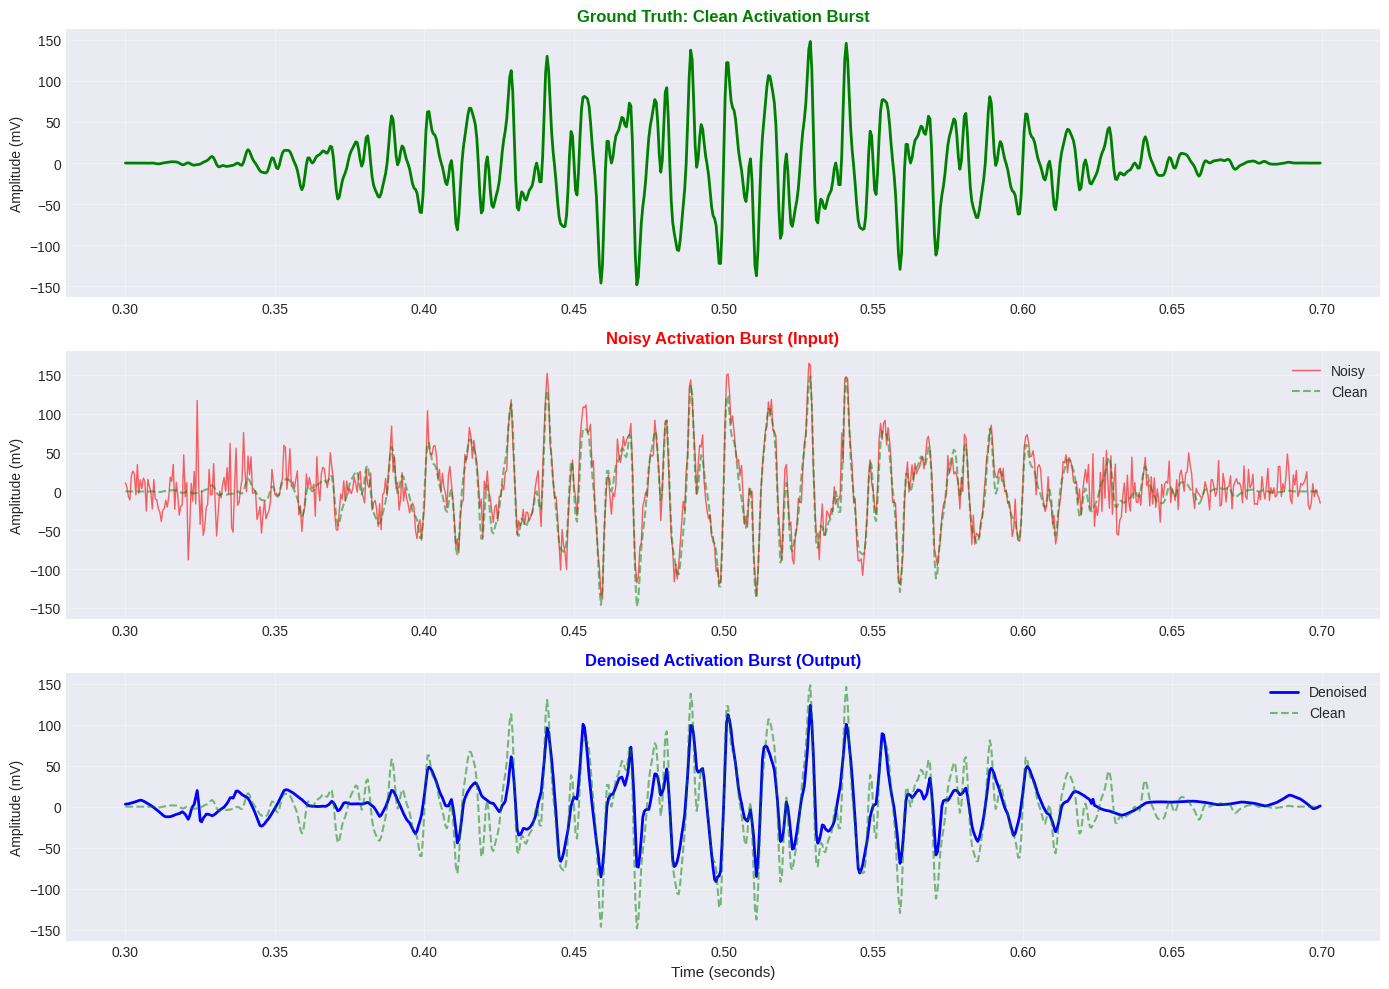

Burst analysis saved as '09_burst_analysis.png'

Activation Burst Metrics:
  Duration: 0.400 seconds
  SNR Before: 6.79 dB
  SNR After: 5.80 dB
  Improvement: -0.99 dB
  Correlation: 0.8797


In [13]:
"""
This zooms in one 1 muscle contractions to show:
- clean burst
- noisy burst
- denoised

Shows: The denoising preserved the shape and timing of the activation
"""
print("\n" + "="*70)
print("SECTION 8: DETAILED ACTIVATION BURST ANALYSIS")
print("="*70)

# Focus on one activation burst
burst_start = int(0.3 * 2000)  # 0.3 seconds
burst_end = int(0.7 * 2000)    # 0.7 seconds

t_burst = t[burst_start:burst_end]
clean_burst = clean_semg[burst_start:burst_end]
noisy_burst = noisy_semg[burst_start:burst_end]
denoised_burst = denoised_semg[burst_start:burst_end]

fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# Clean burst
axes[0].plot(t_burst, clean_burst, 'g-', linewidth=2)
axes[0].set_title('Ground Truth: Clean Activation Burst',
                 fontsize=12, fontweight='bold', color='green')
axes[0].set_ylabel('Amplitude (mV)', fontsize=10)
axes[0].grid(True, alpha=0.3)

# Noisy burst
axes[1].plot(t_burst, noisy_burst, 'r-', alpha=0.6, linewidth=1)
axes[1].plot(t_burst, clean_burst, 'g--', alpha=0.5, linewidth=1.5)
axes[1].set_title('Noisy Activation Burst (Input)',
                 fontsize=12, fontweight='bold', color='red')
axes[1].set_ylabel('Amplitude (mV)', fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].legend(['Noisy', 'Clean'], fontsize=10)

# Denoised burst
axes[2].plot(t_burst, denoised_burst, 'b-', linewidth=2, label='Denoised')
axes[2].plot(t_burst, clean_burst, 'g--', alpha=0.5, linewidth=1.5, label='Clean')
axes[2].set_title('Denoised Activation Burst (Output)',
                 fontsize=12, fontweight='bold', color='blue')
axes[2].set_xlabel('Time (seconds)', fontsize=11)
axes[2].set_ylabel('Amplitude (mV)', fontsize=10)
axes[2].grid(True, alpha=0.3)
axes[2].legend(fontsize=10)

plt.tight_layout()
plt.savefig('09_burst_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("Burst analysis saved as '09_burst_analysis.png'")

# Calculate burst-specific metrics
burst_snr_before = 10 * np.log10(np.sum(clean_burst**2) /
                                 np.sum((noisy_burst - clean_burst)**2))
burst_snr_after = 10 * np.log10(np.sum(clean_burst**2) /
                                np.sum((denoised_burst - clean_burst)**2))
burst_corr = np.corrcoef(clean_burst, denoised_burst)[0, 1]

print(f"\nActivation Burst Metrics:")
print(f"  Duration: {(burst_end - burst_start) / 2000:.3f} seconds")
print(f"  SNR Before: {burst_snr_before:.2f} dB")
print(f"  SNR After: {burst_snr_after:.2f} dB")
print(f"  Improvement: {burst_snr_after - burst_snr_before:.2f} dB")
print(f"  Correlation: {burst_corr:.4f}")

# Section 9: Freq Domain Analysis


SECTION 9: FREQUENCY DOMAIN ANALYSIS


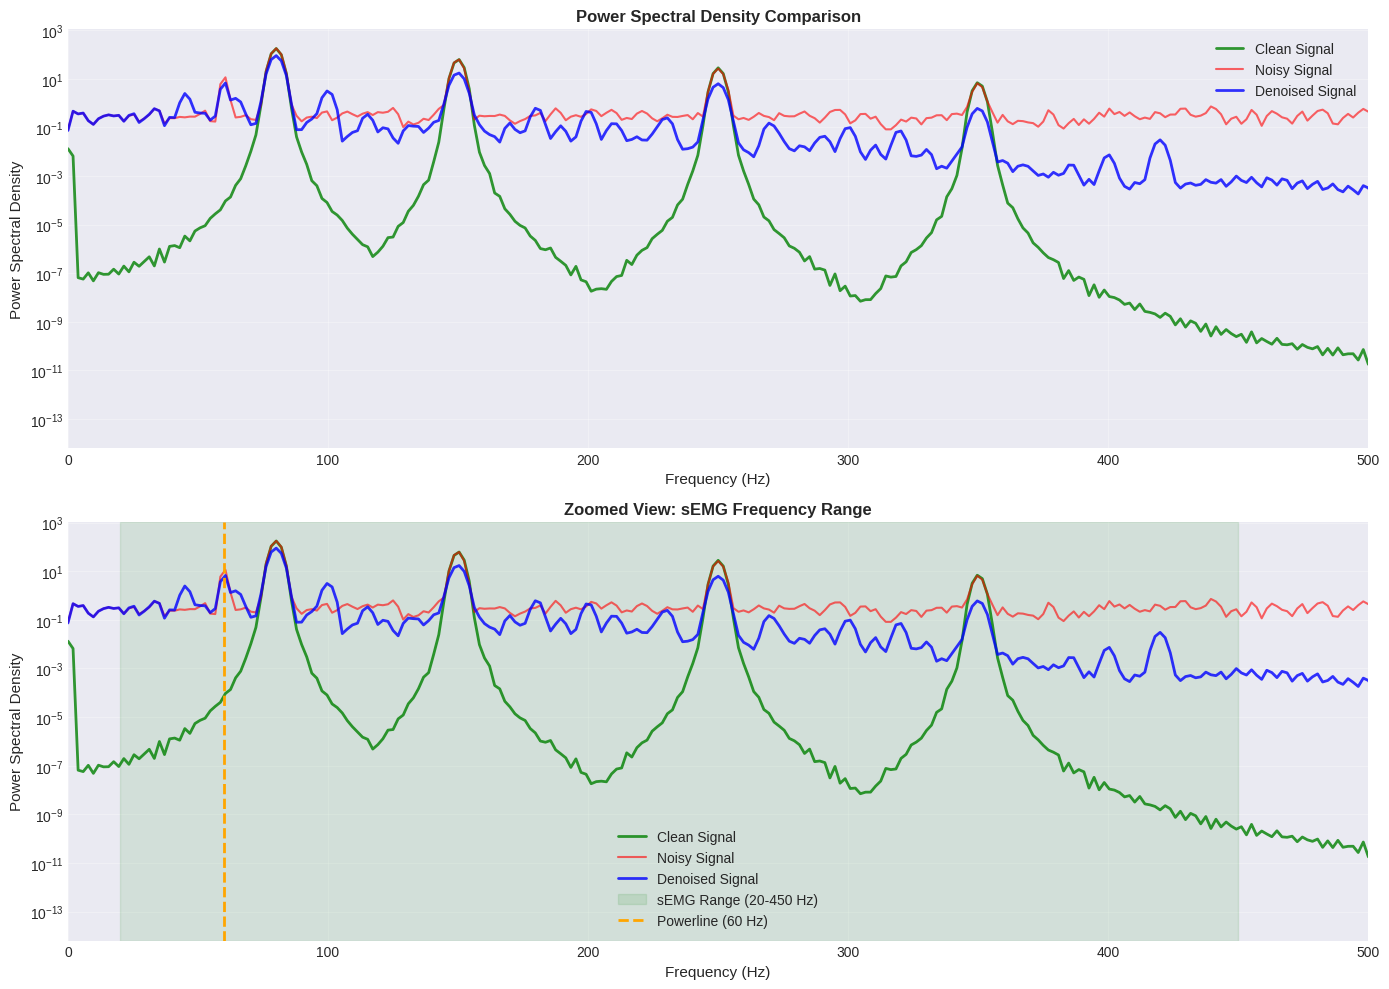

Frequency analysis saved as '10_frequency_analysis.png'

Frequency Domain Metrics (20-450 Hz band):
  Clean signal power: 6.49e+02
  Noisy signal power: 7.32e+02
  Denoised signal power: 3.49e+02
  Power preservation: 53.69%


In [15]:
"""
Shows what happened in freq space

"""
print("\n" + "="*70)
print("SECTION 9: FREQUENCY DOMAIN ANALYSIS")
print("="*70)

from scipy import signal as sp_sig

# Compute power spectral density
freqs_clean, psd_clean = sp_sig.welch(clean_semg, fs=2000, nperseg=1024)
freqs_noisy, psd_noisy = sp_sig.welch(noisy_semg, fs=2000, nperseg=1024)
freqs_denoised, psd_denoised = sp_sig.welch(denoised_semg, fs=2000, nperseg=1024)

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# PSD comparison
axes[0].semilogy(freqs_clean, psd_clean, 'g-', linewidth=2, label='Clean Signal', alpha=0.8)
axes[0].semilogy(freqs_noisy, psd_noisy, 'r-', linewidth=1.5, label='Noisy Signal', alpha=0.6)
axes[0].semilogy(freqs_denoised, psd_denoised, 'b-', linewidth=2, label='Denoised Signal', alpha=0.8)
axes[0].set_xlabel('Frequency (Hz)', fontsize=11)
axes[0].set_ylabel('Power Spectral Density', fontsize=11)
axes[0].set_title('Power Spectral Density Comparison', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim([0, 500])  # Focus on sEMG range

# Zoom into sEMG frequency range
axes[1].semilogy(freqs_clean, psd_clean, 'g-', linewidth=2, label='Clean Signal', alpha=0.8)
axes[1].semilogy(freqs_noisy, psd_noisy, 'r-', linewidth=1.5, label='Noisy Signal', alpha=0.6)
axes[1].semilogy(freqs_denoised, psd_denoised, 'b-', linewidth=2, label='Denoised Signal', alpha=0.8)
axes[1].axvspan(20, 450, alpha=0.1, color='green', label='sEMG Range (20-450 Hz)')
axes[1].axvline(x=60, color='orange', linestyle='--', linewidth=2, label='Powerline (60 Hz)')
axes[1].set_xlabel('Frequency (Hz)', fontsize=11)
axes[1].set_ylabel('Power Spectral Density', fontsize=11)
axes[1].set_title('Zoomed View: sEMG Frequency Range', fontsize=12, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim([0, 500])

plt.tight_layout()
plt.savefig('10_frequency_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("Frequency analysis saved as '10_frequency_analysis.png'")

# Calculate frequency domain metrics
semg_band = (freqs_clean >= 20) & (freqs_clean <= 450)
power_clean = np.sum(psd_clean[semg_band])
power_noisy = np.sum(psd_noisy[semg_band])
power_denoised = np.sum(psd_denoised[semg_band])

print(f"\nFrequency Domain Metrics (20-450 Hz band):")
print(f"  Clean signal power: {power_clean:.2e}")
print(f"  Noisy signal power: {power_noisy:.2e}")
print(f"  Denoised signal power: {power_denoised:.2e}")
print(f"  Power preservation: {100 * power_denoised / power_clean:.2f}%")

# Section 10: Integration with NinaPro Dataset


SECTION 10: INTEGRATION WITH YOUR PIPELINE

Simulating multi-channel sEMG (like NinaPro DB2)...
Generated 2-channel sEMG: shape (4000, 2)
Step 1: Band-pass filtering (20-450 Hz)...
 Filtered signal shape: (4000, 2)

Step 2: Wavelet denoising...
  Denoised signal shape: (4000, 2)

Step 3: Ready for windowing and feature extraction!


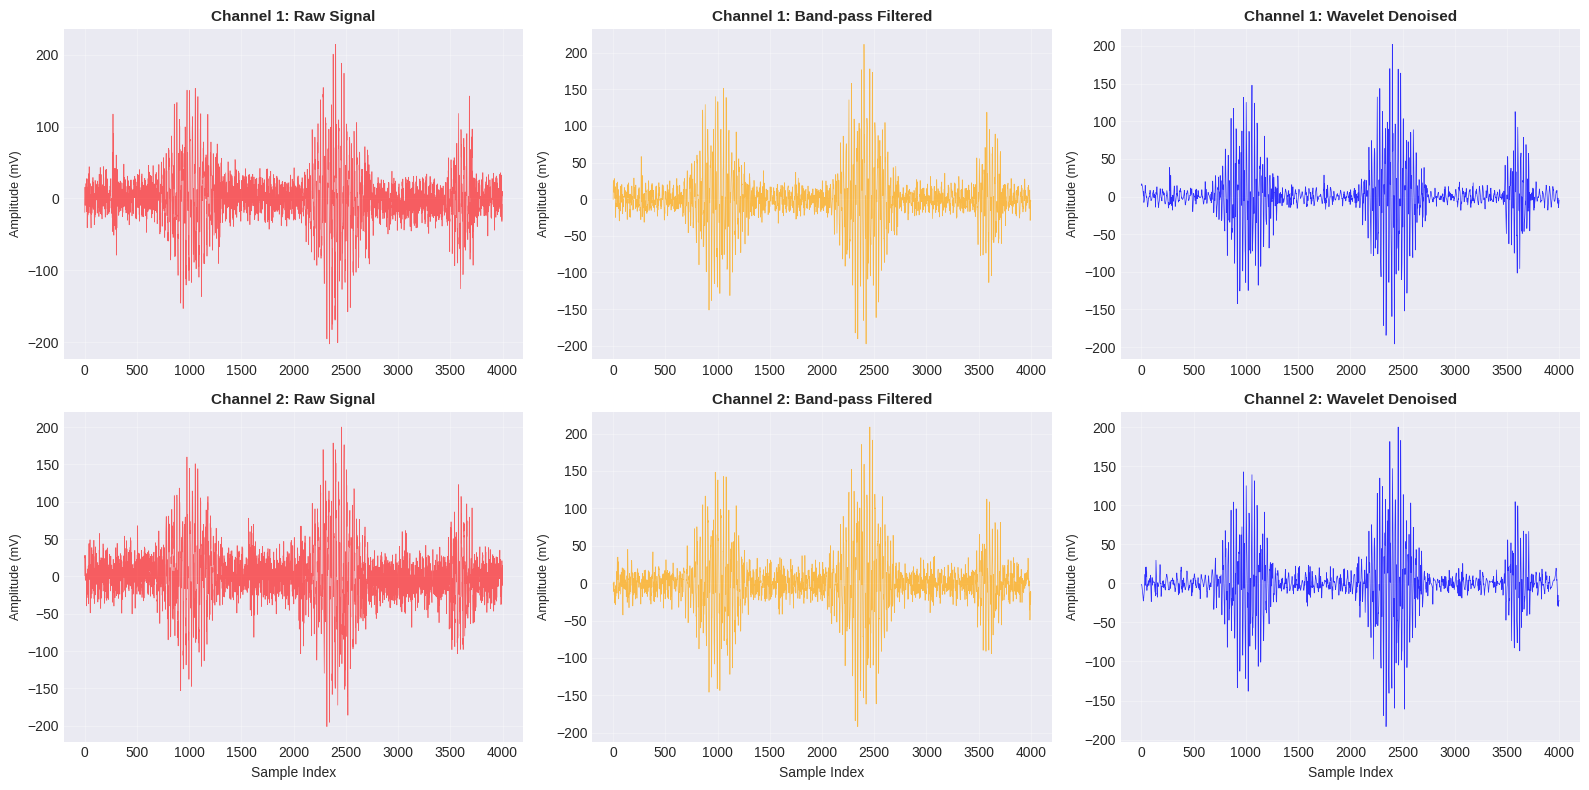


 Pipeline integration saved as '11_pipeline_integration.png'


In [16]:
"""
the Ninapro dataset has 12 channels (12 electrodes on the forearm)
Therefore must process all 12 channels at once
"""

print("\n" + "="*70)
print("SECTION 10: INTEGRATION WITH YOUR PIPELINE")
print("="*70)

def complete_preprocessing_pipeline(emg_raw, fs=2000):
    """
    Complete preprocessing pipeline integrating:
    1. Band-pass filtering (your teammate's module)
    2. Wavelet denoising (your module)
    3. Ready for windowing (your teammate's module)
    """

    print("Step 1: Band-pass filtering (20-450 Hz)...")
    # Design band-pass filter
    nyquist = fs / 2
    low = 20 / nyquist
    high = 450 / nyquist
    b, a = sp_signal.butter(4, [low, high], btype='band')
    emg_filtered = sp_signal.filtfilt(b, a, emg_raw, axis=0)
    print(f" Filtered signal shape: {emg_filtered.shape}")

    print("\nStep 2: Wavelet denoising...")
    if emg_filtered.ndim == 1:
        emg_denoised = wavelet_denoise(emg_filtered, wavelet='sym4', level=4)
    else:
        # Multi-channel processing
        n_samples, n_channels = emg_filtered.shape
        emg_denoised = np.zeros_like(emg_filtered)
        for ch in range(n_channels):
            emg_denoised[:, ch] = wavelet_denoise(emg_filtered[:, ch],
                                                  wavelet='sym4', level=4)
    print(f"  Denoised signal shape: {emg_denoised.shape}")

    print("\nStep 3: Ready for windowing and feature extraction!")

    return emg_filtered, emg_denoised


# Simulate multi-channel EMG (like NinaPro with 12 channels)
print("\nSimulating multi-channel sEMG (like NinaPro DB2)...")
n_channels = 2  # Using 2 for demo (NinaPro has 12)
multi_channel_emg = np.zeros((len(noisy_semg), n_channels))

for ch in range(n_channels):
    # Generate slightly different noise for each channel
    _, _, noisy_ch = generate_synthetic_semg(duration=2.0, fs=2000,
                                            noise_level=15 + ch*2)
    multi_channel_emg[:, ch] = noisy_ch

print(f"Generated {n_channels}-channel sEMG: shape {multi_channel_emg.shape}")

# Apply complete pipeline
filtered_multi, denoised_multi = complete_preprocessing_pipeline(multi_channel_emg)

# Visualize multi-channel processing
fig, axes = plt.subplots(n_channels, 3, figsize=(16, 4*n_channels))

for ch in range(n_channels):
    # Raw
    axes[ch, 0].plot(multi_channel_emg[:, ch], 'r-', alpha=0.6, linewidth=0.5)
    axes[ch, 0].set_title(f'Channel {ch+1}: Raw Signal', fontsize=11, fontweight='bold')
    axes[ch, 0].set_ylabel('Amplitude (mV)', fontsize=9)
    axes[ch, 0].grid(True, alpha=0.3)

    # Filtered
    axes[ch, 1].plot(filtered_multi[:, ch], 'orange', alpha=0.7, linewidth=0.5)
    axes[ch, 1].set_title(f'Channel {ch+1}: Band-pass Filtered', fontsize=11, fontweight='bold')
    axes[ch, 1].set_ylabel('Amplitude (mV)', fontsize=9)
    axes[ch, 1].grid(True, alpha=0.3)

    # Denoised
    axes[ch, 2].plot(denoised_multi[:, ch], 'b-', alpha=0.8, linewidth=0.5)
    axes[ch, 2].set_title(f'Channel {ch+1}: Wavelet Denoised', fontsize=11, fontweight='bold')
    axes[ch, 2].set_ylabel('Amplitude (mV)', fontsize=9)
    axes[ch, 2].grid(True, alpha=0.3)

axes[-1, 0].set_xlabel('Sample Index', fontsize=10)
axes[-1, 1].set_xlabel('Sample Index', fontsize=10)
axes[-1, 2].set_xlabel('Sample Index', fontsize=10)

plt.tight_layout()
plt.savefig('11_pipeline_integration.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n Pipeline integration saved as '11_pipeline_integration.png'")